In [64]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [65]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [66]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [67]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [68]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [69]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [70]:
# Save references to each table
Measurement, Station = Base.classes.measurement, Base.classes.station

In [71]:
# Create our session (link) from Python to the DB
session_link = Session(engine)

# Exploratory Precipitation Analysis

In [72]:
# Find the most recent date in the data set.
session_link.query(Measurement.date).order_by(desc(Measurement.date)).first()[0]


'2017-08-23'

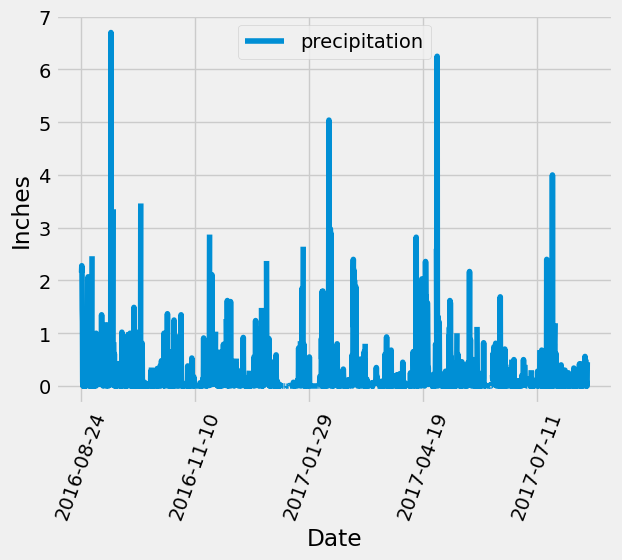

In [77]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = session_link.query(Measurement.date).order_by(desc(Measurement.date)).first()[0]


# Calculate the date one year from the last date in data set.
from datetime import datetime
from dateutil.relativedelta import relativedelta
most_recent_date = datetime.strptime(most_recent, '%Y-%m-%d')
one_year_date = most_recent_date - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
from sqlalchemy import and_
yearly_prcp = session_link.query(Measurement.date, Measurement.prcp).\
    filter(and_(Measurement.date >= one_year_date, Measurement.date <= most_recent_date))

# Save the query results as a Pandas DataFrame. Explicitly set the column names
yearly_prcp_df = pd.DataFrame(yearly_prcp, columns=["date", "precipitation"])

# Sort the dataframe by date
yearly_prcp_df = yearly_prcp_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.pyplot as plt
yearly_prcp_df.plot(x='date', y='precipitation', kind='line')
plt.ylabel("Inches")
plt.xlabel("Date")
plt.xticks(rotation=70)
plt.show()

In [78]:
# Use Pandas to calculate the summary statistics for the precipitation data
yearly_prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [79]:
# Design a query to calculate the total number of stations in the dataset

session_link.query(Measurement.station).distinct().count()

9

In [80]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session_link.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).\
    all()



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [81]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session_link.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter_by(station='USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

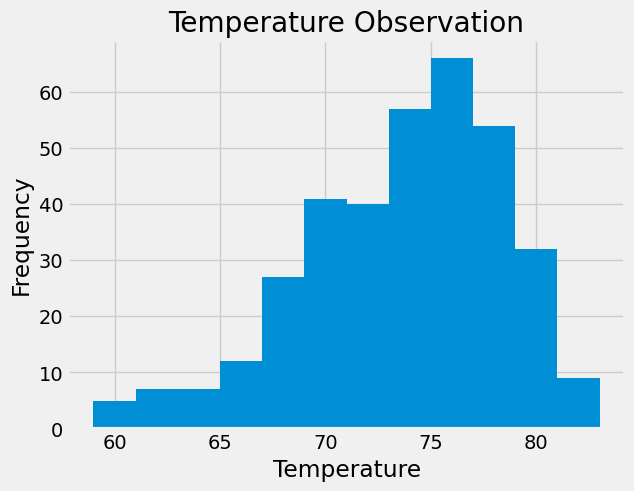

In [82]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


active_station = session_link.query(func.max(Measurement.date)).filter_by(station='USC00519281').first()[0]
last_active = datetime.strptime(active_station, '%Y-%m-%d')
year_from_last_active = (last_active - relativedelta(years=1)).strftime("%Y-%m-%d")

most_active = session_link.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= year_from_last_active).\
    all()

# Create DataFrame
most_active_df = pd.DataFrame(most_active, columns=['tobs'])

# Plot histogram
most_active_df.hist(column='tobs', bins=12)
plt.title("Temperature Observation")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()



# Close Session

In [83]:
# Close Session
session_link.close()